### __Init__

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

import networkx as nx 
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm


import random
import matplotlib.pyplot as plt
from rdkit import Chem
from dataset import create_pytorch_geometric_graph_list, create_dataloaders
from models import odorGIN
from train import train_single_epoch, test, train
import torch
from rdkit.Chem import Draw
from torch_geometric.explain import Explanation, Explainer, ModelConfig
from torch_geometric import explain
from explainer import visualize_molecule_explanation

import sys



### __Dataset__ 

In [2]:
df_path = 'data/Multi-Labelled_Smiles_Odors_dataset.csv'
odor_df = pd.read_csv(df_path)

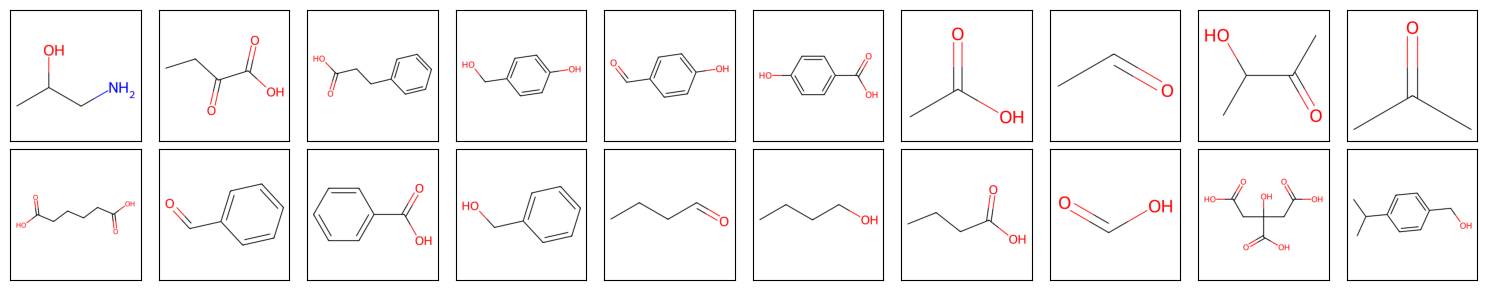

In [3]:
# Molecule Visualization 
nrows, ncols = 2, 10

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3))
for i in range(nrows*ncols):
    m = Chem.MolFromSmiles(odor_df['nonStereoSMILES'][i])
    img = Draw.MolToImage(m)
    axs[i//ncols][i%ncols].imshow(img)
    axs[i//ncols][i%ncols].set_xticks([])
    axs[i//ncols][i%ncols].set_yticks([])   
plt.xticks([])
plt.yticks([])
fig.tight_layout()
plt.show()

In [4]:
X = odor_df.iloc[:, 0]
classes = odor_df.columns[2:]
y = odor_df.iloc[:, 2:].values

graph_list = create_pytorch_geometric_graph_list(X, y)
graph_list[0: 5]


[Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[138], smiles='CC(O)CN'),
 Data(x=[7, 11], edge_index=[2, 12], edge_attr=[12, 4], y=[138], smiles='CCC(=O)C(=O)O'),
 Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[138], smiles='O=C(O)CCc1ccccc1'),
 Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[138], smiles='OCc1ccc(O)cc1'),
 Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[138], smiles='O=Cc1ccc(O)cc1')]

In [5]:
batch_size, use_shuffle = 1, True
train_set, val_set, test_set,  train_loader, val_loader, test_loader = create_dataloaders(graph_list, 0.7, 0.2, 0.1, batch_size)

# hyperparamters 
hidden_channels = 64
num_layers = 2
dropout_p = 0
pooling_type = 'mean'
in_channels = list(graph_list[0].x.shape)[-1]
out_channels = 1 
num_epochs = 50
lr = 1e-4
weight_decay = 1e-6


model_GIN = odorGIN.OdorGIN(in_channels, hidden_channels, num_layers)
optimizer = torch.optim.Adam(model_GIN.parameters(), lr=lr, weight_decay=weight_decay)

In [18]:
from torch_geometric.nn import summary
import tabulate

next(iter(train_loader))
x = torch.randn(10, 11)
edge_index = torch.randint(10, size=(2, 20))
edge_attr = torch.rand(size=(20, 4))
print(summary(model_GIN, x, edge_index, edge_attr))

+-------------------------------+----------------------------+----------------+----------+
| Layer                         | Input Shape                | Output Shape   | #Param   |
|-------------------------------+----------------------------+----------------+----------|
| OdorGIN                       | [10, 11], [2, 20], [20, 4] | [1, 138]       | 22,218   |
| ├─(gnn)GIN                    | [10, 11], [2, 20]          | [10, 64]       | 13,248   |
| │    └─(dropout)Dropout       | [10, 64]                   | [10, 64]       | --       |
| │    └─(act)ReLU              | [10, 64]                   | [10, 64]       | --       |
| │    └─(convs)ModuleList      | --                         | --             | 13,248   |
| │    │    └─(0)GINConv        | [10, 11], [2, 20]          | [10, 64]       | 4,928    |
| │    │    └─(1)GINConv        | [10, 64], [2, 20]          | [10, 64]       | 8,320    |
| │    └─(norms)ModuleList      | --                         | --             | --       |

In [29]:
import torch 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb.plot 
from utils import plot_losses
from sklearn.metrics import f1_score, roc_auc_score
import wandb
# from torch_geometric.nn import save_pretrained


def plot_util(train_losses, val_losses, title=None):
    """Utility method to plot paired loss curves"""
    # print(train_accs, val_accs)
    plt.plot(range(len(val_losses)), val_losses, label='val')
    plt.plot(range(len(train_losses)), train_losses, label='train')
    plt.legend()
    plt.title(title)
    plt.show()



# WIP: Hyperparameter tuning, save best model, 

softmax_cutoff = 0.005

def train_single_epoch(model, optimizer, train_loader, mode):
    '''
    Train model for one epoch
    '''

    if mode == "train":
        model.train()
    elif mode == "val" or mode == "test":
        model.eval()

    total_loss = 0
    for data in train_loader:
        # data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = torch.nn.CrossEntropyLoss()(out.squeeze(), data.y)

        if mode == "train":
            loss.backward()
            optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)  



@torch.no_grad()
def test(model, loader):
    '''
    Test the model on test loader 
    '''

    model.eval()
    total_correct = 0
    total_ex = 0 
    all_preds = []
    all_true = [] 
    for data in loader:
        # data = data.to(device)

        pred = model(data.x, data.edge_index, data.batch)
        pred = (pred.squeeze() >= softmax_cutoff).float()


        total_correct += int((pred == data.y).sum()) 
        total_ex += np.prod(data.y.shape) 

        all_preds.append(pred)
        all_true.append(data.y)
    return total_correct / total_ex, torch.vstack(all_preds), torch.vstack(all_true)




def train_model(model, num_epochs, lr, weight_decay, train_loader, val_loader):
    '''
    Train or finetune the given model using the train/val sets
    '''

    run = wandb.init(project="odor-gnn")
    wandb.config = {"epochs": 5, "learning_rate": lr, "batch_size": batch_size}

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_accs, test_accs, train_losses, val_losses = [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        train_loss = train_single_epoch(model, optimizer, train_loader, 'train')
        val_loss = train_single_epoch(model, optimizer, val_loader, 'val')
        train_acc, train_preds, train_true  = test(model, train_loader)
        test_acc, test_preds, test_true = test(model, val_loader)

        wandb.log({"Train Accuracy": train_acc, "Train Loss": train_loss, "Val Accuracy": test_acc, "Val Loss": val_loss})
        
        # track metrics
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if (train_accs== [] or train_acc > max(train_accs)):
            torch.save(model.state_dict(), 'models/gin-best-model.pth')
            artifact = wandb.Artifact('model', type='model')
            artifact.add_file('models/gin-best-model.pth')
            run.log_artifact(artifact)


    run.finish()
    return train_losses, val_losses, train_accs, test_accs


In [20]:
model = odorGIN.OdorGIN(in_channels, hidden_channels,  num_layers )
train_losses, val_losses, train_accs, test_accs = train_model(model, num_epochs, lr, weight_decay, train_loader, val_loader)


100%|██████████| 50/50 [04:14<00:00,  5.09s/it]


Train Accuracy,▁▄▅▆▅▅▄▅▆▅▆▆▆▆▇▆▇▇▆▇▇▇▆▇▇▇▇▇▇▆▆▇█▇▇█▇███
Train Loss,█▇▆▆▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
Val Accuracy,▁▄▆▆▆▆▅▅▆▅▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇██
Val Loss,██▇▇▇▇█▅▄▄▄▅▄▅▃▄▄▃▂▂▂▂▂▂▁▁▁▁▃▂▂▁▁▁▁▂▁▁▂▁
Train Accuracy,0.96399
Train Loss,23.77244
Val Accuracy,0.96508
Val Loss,22.98672


___
___

### __Hyperparameter Tuning__ 

In [30]:
def hyp_tuning():
    wandb.init()
    lr = wandb.config['learning_rate']
    # epochs = wandb.config.epochs
    model = odorGIN.OdorGIN(in_channels, hidden_channels, num_layers, 138, wandb.config.dropout, wandb.config['pool_type'])
    train_model(model, num_epochs, lr, weight_decay, train_loader, val_loader)


sweep_configuration = {
    "method": "random",
    "metric": {"goal": "maximize", "name": "test_acc"},
    "parameters": {
        "dropout": {"min": 0.0, 'max': 0.2},
        "learning_rate": {"min": 0.0001, "max": 0.001},
        "pool_type": {"values": ['mean', 'max', 'add']},
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="odor-gnn")
wandb.agent(sweep_id, function=hyp_tuning, count=10)

Create sweep with ID: x8wot23q
Sweep URL: https://wandb.ai/vanshagarwal11-prom-iit-rajasthan/odor-gnn/sweeps/x8wot23q


wandb: Agent Starting Run: lss8e410 with config:
wandb: 	dropout: 0.14671892724519042
wandb: 	learning_rate: 0.000143364521095733
wandb: 	pool_type: mean


wandb: 🚀 View run azure-sweep-2 at: https://wandb.ai/vanshagarwal11-prom-iit-rajasthan/odor-gnn/runs/vrgup8nf
wandb: Find logs at: wandb/run-20241022_040326-vrgup8nf/logs


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:19<00:00,  5.19s/it]


Train Accuracy,▁▃▄▁▂▂▂▄▃▅▃▄▅▆▆▇▅▇▆▆▆▆▅▇▆▇▆▆▇▇▇▇▇█▇▇▇███
Train Loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Val Accuracy,▂▄▂▃▅▁▃▂▅▄▃▆▆▆▆▇▅▇▆▅▇▆▅█▅▇▆▆▇▇▇▆██▇▇▆███
Val Loss,▇▆█▇▄▄▅▄▃▂▃▂▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁
Train Accuracy,0.96432
Train Loss,23.75971
Val Accuracy,0.9653
Val Loss,22.98286


wandb: Agent Starting Run: 97y0u7pe with config:
wandb: 	dropout: 0.10360211628908755
wandb: 	learning_rate: 0.0007557608130413749
wandb: 	pool_type: max


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:20<00:00,  5.21s/it]


Train Accuracy,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▁▁▁▁▂███████████████████████████████████
Val Accuracy,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁█████████████████████████████████████
Train Accuracy,0.95762
Train Loss,24.28626
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: bedlgh9i with config:
wandb: 	dropout: 0.10104350601121762
wandb: 	learning_rate: 0.0009743563548409898
wandb: 	pool_type: max


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


Train Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▁███████████████████████████████████████
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.95762
Train Loss,24.2863
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: iuzkg549 with config:
wandb: 	dropout: 0.06309907353364157
wandb: 	learning_rate: 0.00011443107337520144
wandb: 	pool_type: mean


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


Train Accuracy,▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▅▅▅▅▆▅▅▅▆▅▁▂▂▆▆█▇██▇
Train Loss,█▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▁▁▁▁▁▁▁
Val Accuracy,▁▄▅▅▆▅▅▅▅▆▆▆▅▆▆▆▅▅▆▆▆▆▆▆▆▆▆▅▆▆▃▃▃▇▆▇█▇██
Val Loss,████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▄▄▃▂▂▁▁▁▁▂
Train Accuracy,0.96348
Train Loss,23.84858
Val Accuracy,0.96477
Val Loss,23.05362


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t9b5dzf9 with config:
wandb: 	dropout: 0.1744356926756927
wandb: 	learning_rate: 0.0007667773125307092
wandb: 	pool_type: add


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


Train Accuracy,████████████████▁█████████████████████▁█
Train Loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.95762
Train Loss,24.28626
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: 591nav3q with config:
wandb: 	dropout: 0.19991271726732185
wandb: 	learning_rate: 0.0005295266048464068
wandb: 	pool_type: add


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:13<00:00,  5.07s/it]


Train Accuracy,▁███████████████████████████████████████
Train Loss,▁███████████████████████████████████████
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.95762
Train Loss,24.28626
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: xqrgdg0b with config:
wandb: 	dropout: 0.11078040605952272
wandb: 	learning_rate: 0.00017598398629701183
wandb: 	pool_type: max


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


Train Accuracy,▁▄▇██▇██████████████████████████████████
Train Loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▇█▇▇█████████████████▇▇████████████████
Val Loss,█▅▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.9629
Train Loss,23.92197
Val Accuracy,0.96416
Val Loss,23.12698


wandb: Agent Starting Run: 56byjc6q with config:
wandb: 	dropout: 0.0745147509015246
wandb: 	learning_rate: 0.00094884747835527
wandb: 	pool_type: add


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [21:25<00:00, 25.70s/it]   


Train Accuracy,█▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▂▁▁▃███████████████████████████████▄████
Val Accuracy,█▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁█████████████████████████████████████
Train Accuracy,0.95762
Train Loss,24.28631
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: 4w6buqi7 with config:
wandb: 	dropout: 0.1660425344079146
wandb: 	learning_rate: 0.00034305116176122885
wandb: 	pool_type: add


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:16<00:00,  5.13s/it]


Train Accuracy,▁███████████████████████████████████████
Train Loss,▁███████████████████████████████████████
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.95762
Train Loss,24.28626
Val Accuracy,0.95881
Val Loss,23.49746


wandb: Agent Starting Run: 6c52893l with config:
wandb: 	dropout: 0.10865897302329068
wandb: 	learning_rate: 0.0007153890540756101
wandb: 	pool_type: max


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


Train Accuracy,▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁▁▁▇▇▇▅▇▂███▇█████▇███▇██▇
Train Loss,▃▂▂▂▂▃▂▂▂▂▂▇███▇▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
Val Accuracy,▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁▁▁▇▇▇▅▅▇▂█▇█▇███▇▇██▇▇██▇
Val Loss,▂▂▂▂▂▂▂▂▂▂▂█████▂▂▂▃▁▆▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂
Train Accuracy,0.96282
Train Loss,23.9277
Val Accuracy,0.96402
Val Loss,23.13703


### __Model Embeddings__

In [154]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings(model, graph_list, title=None, savepath=None):
    """Visualize model embeddings for graphs in graph_list via PCA and t-SNE."""
    # look just at GNN + pooling
    emb_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    )

    if model is not None:
        print('loading state dict')
        emb_model.gnn.load_state_dict(
            model.gnn.state_dict()
        )

    # generate embeddings
    coords = []
    labels = []
    for graph_data in graph_list:
        graph_data = graph_data
        readout = emb_model(graph_data.x, graph_data.edge_index, batch=torch.tensor([0]))
        coords.append(readout.squeeze())
        labels.append(graph_data.y.item())

    X = torch.vstack(coords).detach().numpy()

    pca = PCA(n_components=30)
    X_pca = pca.fit_transform(X)

    X_embedded = TSNE(n_components=2).fit_transform(X_pca)
    # X_embedded = X_pca

    labels = np.array(labels)

    plt.scatter(X_embedded[(labels==0), 0], X_embedded[(labels==0), 1], c='#fcbf49', s=35, label='not pungent', alpha=0.3)
    plt.scatter(X_embedded[(labels==1), 0], X_embedded[(labels==1), 1], c='#c1121f', s=35, label='pungent', alpha=0.3)
    plt.legend()
    # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['red' if x else 'blue' for x in labels], s=0.2)
    if title:
        plt.title(title)

    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

plot_embeddings(model, graph_list,  title='t-SNE embedding visualization: after training', savepath='tsne_embedding')

loading state dict


RuntimeError: Error(s) in loading state_dict for GIN:
	Unexpected key(s) in state_dict: "convs.0._edge_mask". 